# Generating SQL for SQLite using Ollama, ChromaDB

In [ ]:
%pip install 'vanna[chromadb]'

In [3]:
from vanna.ollama import Ollama
from vanna.chromadb import ChromaDB_VectorStore

In [4]:
class MyVanna(ChromaDB_VectorStore, Ollama):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Ollama.__init__(self, config=config)

vn = MyVanna(config={'model': 'llama3:8b'})

In [5]:
vn.connect_to_sqlite('world_layoffs.db')

## Training
You only need to train once. Do not train again unless you want to add more training data.

In [4]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

for ddl in df_ddl['sql'].to_list():
  vn.train(ddl=ddl)

Adding ddl: CREATE TABLE "layoffs"(`company` TEXT, `location` TEXT, `industry` TEXT, `total_laid_off` TEXT, `percentage_laid_off` TEXT, `date` TEXT, `stage` TEXT, `country` TEXT, `funds_raised_millions` TEXT)
Adding ddl: CREATE TABLE layoffs_staging(
  company TEXT,
  location TEXT,
  industry TEXT,
  total_laid_off TEXT,
  percentage_laid_off TEXT,
  date TEXT,
  stage TEXT,
  country TEXT,
  funds_raised_millions TEXT
)
Adding ddl: CREATE TABLE `layoffs_staging2`(
  company TEXT,
  location TEXT,
  industry TEXT,
  total_laid_off TEXT,
  percentage_laid_off TEXT,
  date TEXT,
  stage TEXT,
  country TEXT,
  funds_raised_millions TEXT,
  row_num INTEGER
)
Adding ddl: CREATE TABLE `layoffs-copy`(`company` TEXT, `location` TEXT, `industry` TEXT, `total_laid_off` TEXT, `percentage_laid_off` TEXT, `date` TEXT, `stage` TEXT, `country` TEXT, `funds_raised_millions` TEXT)


In [ ]:

# The following are methods for adding training data. Make sure you modify the examples to match your database.

# DDL statements are powerful because they specify table names, colume names, types, and potentially relationships
vn.train(ddl="""
    CREATE TABLE IF NOT EXISTS my-table (
        id INT PRIMARY KEY,
        name VARCHAR(100),
        age INT
    )
""")

# Sometimes you may want to add documentation about your business terminology or definitions.
vn.train(documentation="Our business defines OTIF score as the percentage of orders that are delivered on time and in full")

# You can also add SQL queries to your training data. This is useful if you have some queries already laying around. You can just copy and paste those from your editor to begin generating new SQL.
vn.train(sql="SELECT * FROM my-table WHERE name = 'John Doe'")


In [6]:
# At any time you can inspect what training data the package is able to reference
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type
0,14ef14ac-5e71-54d0-b6b1-40a2f167bd13-sql,show all tables,SELECT name FROM sqlite_master WHERE type='tab...,sql
1,305ba0ed-dc0f-52b0-9905-f3a46a076efd-sql,lets preview dupliated rows,"SELECT * FROM ""layoffs"" GROUP BY company, loca...",sql
0,0fab37d6-439f-5f2c-9d62-d1efa49c89c3-ddl,None,"CREATE TABLE `layoffs-copy`(`company` TEXT, `l...",ddl
1,1ebf26e2-a92d-5c90-8c1c-a3c9ce12c2a3-ddl,None,"CREATE TABLE layoffs_staging(\n company TEXT,...",ddl
2,f0b392d4-f9bb-5f94-a7a9-7adcd5c167b3-ddl,None,CREATE TABLE `layoffs_staging2`(\n company TE...,ddl
3,f7e0adab-f636-54b3-9890-3bd3bbbe2607-ddl,None,"CREATE TABLE ""layoffs""(`company` TEXT, `locati...",ddl


In [ ]:
# You can remove training data if there's obsolete/incorrect information. 
vn.remove_training_data(id='1-ddl')


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4


[{'role': 'system', 'content': 'The user provides a question and you provide SQL. You will only respond with SQL code and not with any explanations.\n\nRespond with only SQL code. Do not answer with any explanations -- just the code.\n\nYou may use the following DDL statements as a reference for what tables might be available. Use responses to past questions also to guide you:\n\nCREATE TABLE `layoffs-copy`(`company` TEXT, `location` TEXT, `industry` TEXT, `total_laid_off` TEXT, `percentage_laid_off` TEXT, `date` TEXT, `stage` TEXT, `country` TEXT, `funds_raised_millions` TEXT)\n\nCREATE TABLE "layoffs"(`company` TEXT, `location` TEXT, `industry` TEXT, `total_laid_off` TEXT, `percentage_laid_off` TEXT, `date` TEXT, `stage` TEXT, `country` TEXT, `funds_raised_millions` TEXT)\n\nCREATE TABLE `layoffs_staging2`(\n  company TEXT,\n  location TEXT,\n  industry TEXT,\n  total_laid_off TEXT,\n  percentage_laid_off TEXT,\n  date TEXT,\n  stage TEXT,\n  country TEXT,\n  funds_raised_millions TE

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


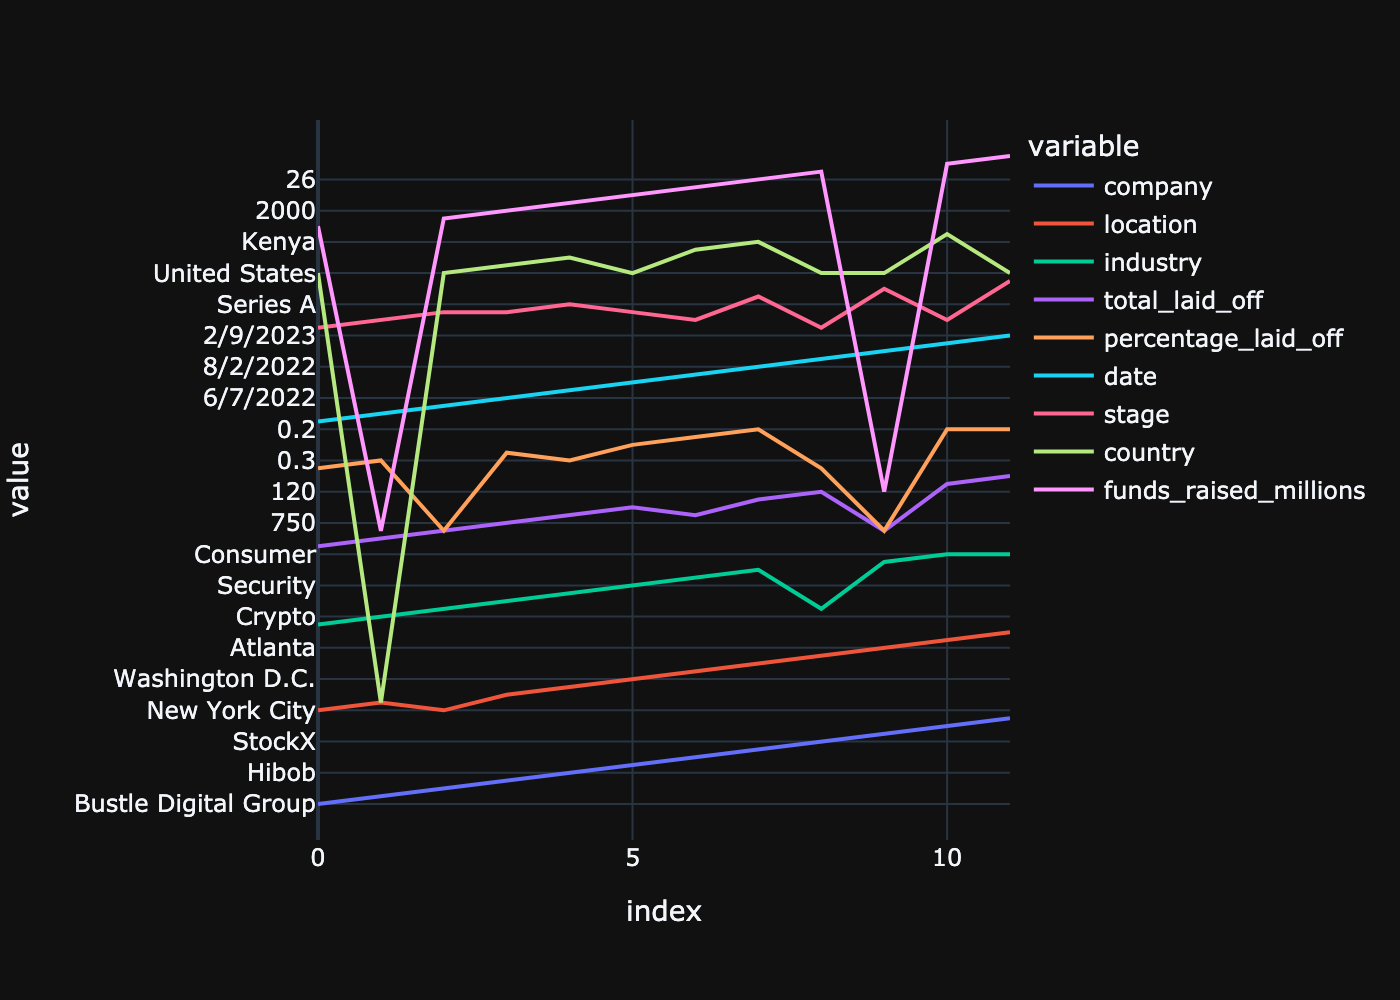

('SELECT * FROM "layoffs" GROUP BY company, location, industry, date HAVING COUNT(*) > 1;',
                  company         location        industry total_laid_off  \
 0   Bustle Digital Group    New York City           Media             24   
 1                  Bybit        Singapore          Crypto            600   
 2                 Casper    New York City          Retail           NULL   
 3                  Cazoo           London  Transportation            750   
 4                  Hibob         Tel Aviv              HR             70   
 5                IronNet  Washington D.C.        Security             90   
 6                    Oda             Oslo            Food             70   
 7                  Sendy          Nairobi       Logistics             54   
 8                 StockX          Detroit          Retail            120   
 9               Terminus          Atlanta       Marketing           NULL   
 10      Wildlife Studios        Sao Paulo        Consumer   

In [7]:
vn.ask(question='lets check for duplicates')

Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4


[{'role': 'system', 'content': 'The user provides a question and you provide SQL. You will only respond with SQL code and not with any explanations.\n\nRespond with only SQL code. Do not answer with any explanations -- just the code.\n\nYou may use the following DDL statements as a reference for what tables might be available. Use responses to past questions also to guide you:\n\nCREATE TABLE `layoffs-copy`(`company` TEXT, `location` TEXT, `industry` TEXT, `total_laid_off` TEXT, `percentage_laid_off` TEXT, `date` TEXT, `stage` TEXT, `country` TEXT, `funds_raised_millions` TEXT)\n\nCREATE TABLE `layoffs_staging2`(\n  company TEXT,\n  location TEXT,\n  industry TEXT,\n  total_laid_off TEXT,\n  percentage_laid_off TEXT,\n  date TEXT,\n  stage TEXT,\n  country TEXT,\n  funds_raised_millions TEXT,\n  row_num INTEGER\n)\n\nCREATE TABLE "layoffs"(`company` TEXT, `location` TEXT, `industry` TEXT, `total_laid_off` TEXT, `percentage_laid_off` TEXT, `date` TEXT, `stage` TEXT, `country` TEXT, `fun

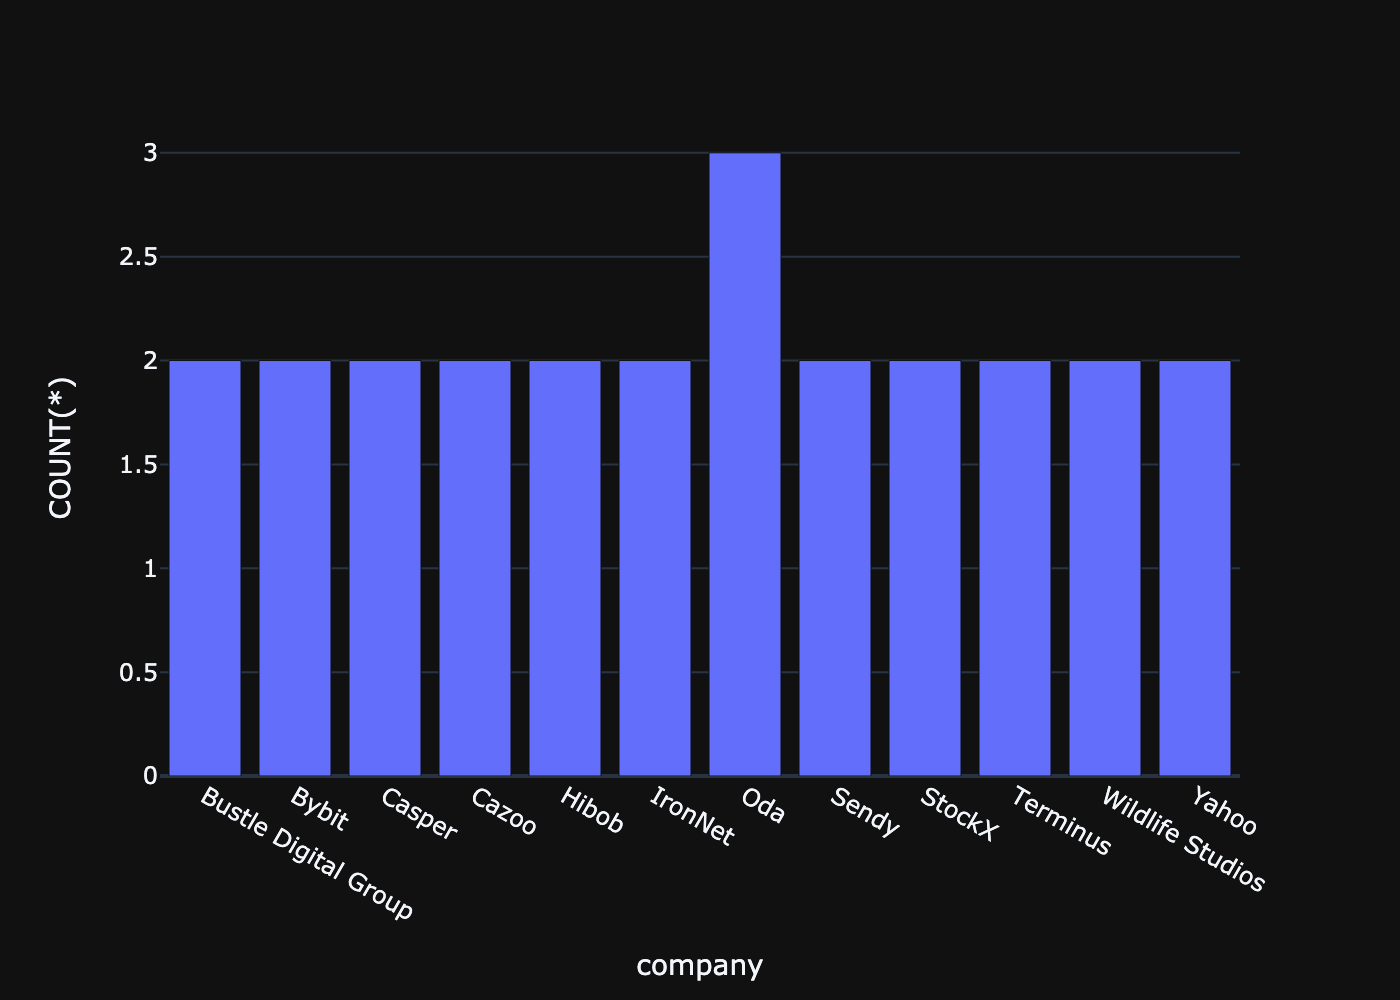

('SELECT COUNT(*), company, location, industry, date FROM "layoffs" GROUP BY company, location, industry, date HAVING COUNT(*) > 1;',
     COUNT(*)               company         location        industry  \
 0          2  Bustle Digital Group    New York City           Media   
 1          2                 Bybit        Singapore          Crypto   
 2          2                Casper    New York City          Retail   
 3          2                 Cazoo           London  Transportation   
 4          2                 Hibob         Tel Aviv              HR   
 5          2               IronNet  Washington D.C.        Security   
 6          3                   Oda             Oslo            Food   
 7          2                 Sendy          Nairobi       Logistics   
 8          2                StockX          Detroit          Retail   
 9          2              Terminus          Atlanta       Marketing   
 10         2      Wildlife Studios        Sao Paulo        Consumer   
 1

In [8]:
vn.ask(question='count duplicates')

Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4


[{'role': 'system', 'content': 'The user provides a question and you provide SQL. You will only respond with SQL code and not with any explanations.\n\nRespond with only SQL code. Do not answer with any explanations -- just the code.\n\nYou may use the following DDL statements as a reference for what tables might be available. Use responses to past questions also to guide you:\n\nCREATE TABLE `layoffs-copy`(`company` TEXT, `location` TEXT, `industry` TEXT, `total_laid_off` TEXT, `percentage_laid_off` TEXT, `date` TEXT, `stage` TEXT, `country` TEXT, `funds_raised_millions` TEXT)\n\nCREATE TABLE `layoffs_staging2`(\n  company TEXT,\n  location TEXT,\n  industry TEXT,\n  total_laid_off TEXT,\n  percentage_laid_off TEXT,\n  date TEXT,\n  stage TEXT,\n  country TEXT,\n  funds_raised_millions TEXT,\n  row_num INTEGER\n)\n\nCREATE TABLE "layoffs"(`company` TEXT, `location` TEXT, `industry` TEXT, `total_laid_off` TEXT, `percentage_laid_off` TEXT, `date` TEXT, `stage` TEXT, `country` TEXT, `fun

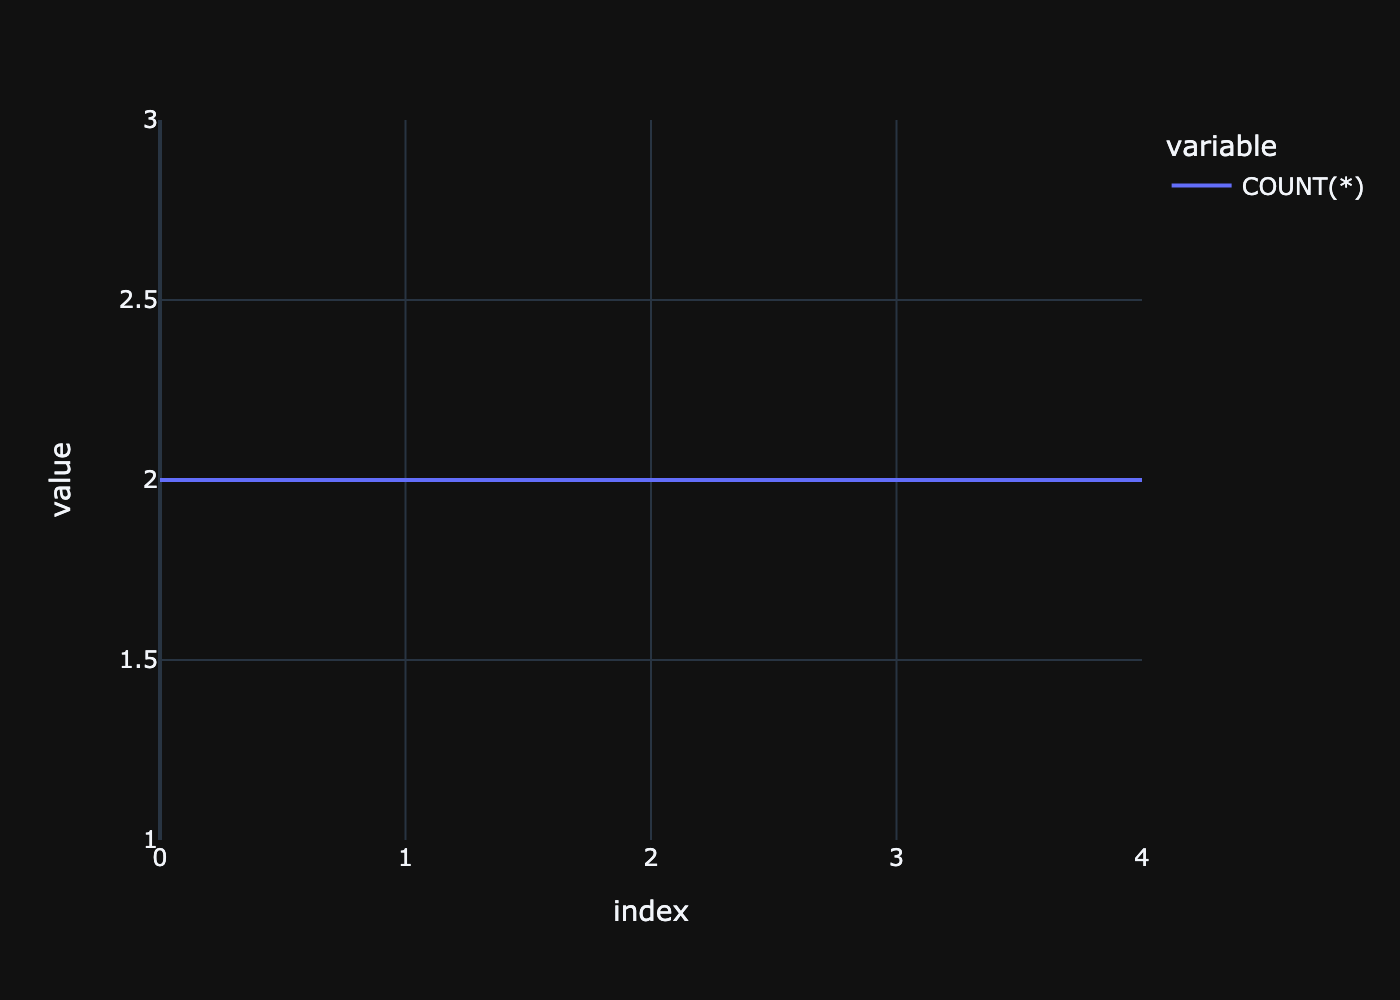

('SELECT COUNT(*)\nFROM "layoffs"\nGROUP BY company, location, industry, total_laid_off, percentage_laid_off, date, stage, country, funds_raised_millions\nHAVING COUNT(*) > 1;',
    COUNT(*)
 0         2
 1         2
 2         2
 3         2
 4         2,
 None)

In [9]:
vn.ask(question='count duplicates based on all columns')

In [10]:
vn.ask(question='remove duplicates based on all columns where count > 1')

Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4


[{'role': 'system', 'content': 'The user provides a question and you provide SQL. You will only respond with SQL code and not with any explanations.\n\nRespond with only SQL code. Do not answer with any explanations -- just the code.\n\nYou may use the following DDL statements as a reference for what tables might be available. Use responses to past questions also to guide you:\n\nCREATE TABLE `layoffs-copy`(`company` TEXT, `location` TEXT, `industry` TEXT, `total_laid_off` TEXT, `percentage_laid_off` TEXT, `date` TEXT, `stage` TEXT, `country` TEXT, `funds_raised_millions` TEXT)\n\nCREATE TABLE `layoffs_staging2`(\n  company TEXT,\n  location TEXT,\n  industry TEXT,\n  total_laid_off TEXT,\n  percentage_laid_off TEXT,\n  date TEXT,\n  stage TEXT,\n  country TEXT,\n  funds_raised_millions TEXT,\n  row_num INTEGER\n)\n\nCREATE TABLE "layoffs"(`company` TEXT, `location` TEXT, `industry` TEXT, `total_laid_off` TEXT, `percentage_laid_off` TEXT, `date` TEXT, `stage` TEXT, `country` TEXT, `fun

Number of requested results 10 is greater than number of elements in index 7, updating n_results = 7
Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4


[{'role': 'system', 'content': 'The user provides a question and you provide SQL. You will only respond with SQL code and not with any explanations.\n\nRespond with only SQL code. Do not answer with any explanations -- just the code.\n\nYou may use the following DDL statements as a reference for what tables might be available. Use responses to past questions also to guide you:\n\nCREATE TABLE `layoffs_staging2`(\n  company TEXT,\n  location TEXT,\n  industry TEXT,\n  total_laid_off TEXT,\n  percentage_laid_off TEXT,\n  date TEXT,\n  stage TEXT,\n  country TEXT,\n  funds_raised_millions TEXT,\n  row_num INTEGER\n)\n\nCREATE TABLE layoffs_staging(\n  company TEXT,\n  location TEXT,\n  industry TEXT,\n  total_laid_off TEXT,\n  percentage_laid_off TEXT,\n  date TEXT,\n  stage TEXT,\n  country TEXT,\n  funds_raised_millions TEXT\n)\n\nCREATE TABLE `layoffs-copy`(`company` TEXT, `location` TEXT, `industry` TEXT, `total_laid_off` TEXT, `percentage_laid_off` TEXT, `date` TEXT, `stage` TEXT, `c

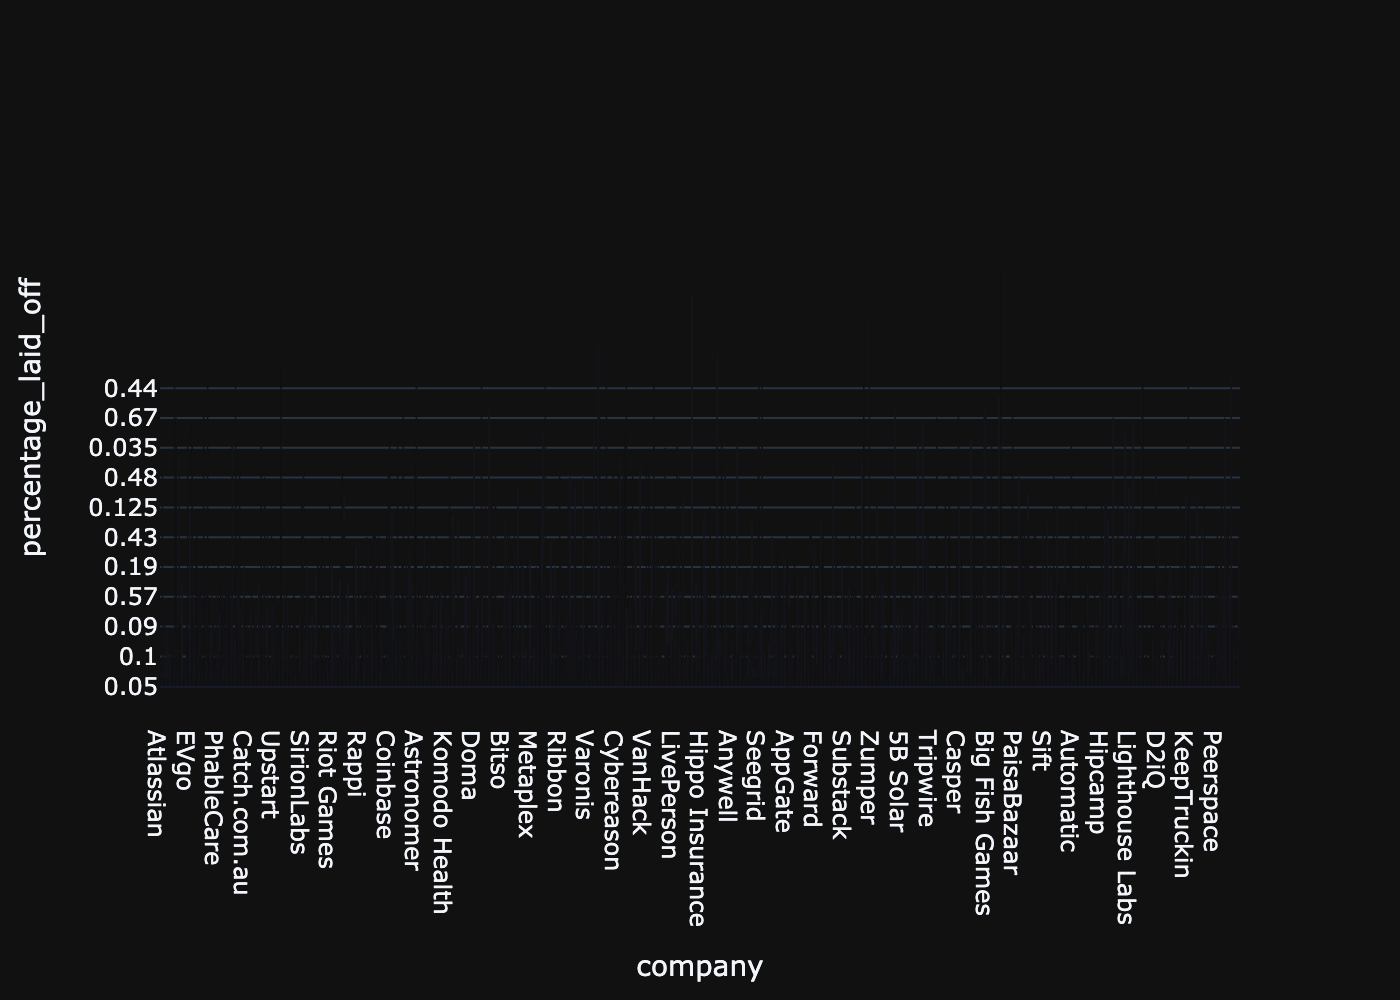

('SELECT * FROM "layoffs";',
                company       location     industry total_laid_off  \
 0            Atlassian         Sydney        Other            500   
 1             SiriusXM  New York City        Media            475   
 2               Alerzo         Ibadan       Retail            400   
 3               UpGrad         Mumbai    Education            120   
 4                 Loft      Sao Paulo  Real Estate            340   
 ...                ...            ...          ...            ...   
 2356         Blackbaud     Charleston        Other            500   
 2357             Yahoo    SF Bay Area     Consumer           1600   
 2358             Hibob       Tel Aviv           HR             70   
 2359            Casper  New York City       Retail           NULL   
 2360  Wildlife Studios      Sao Paulo     Consumer            300   
 
      percentage_laid_off        date     stage        country  \
 0                   0.05    3/6/2023  Post-IPO      Australia 

In [13]:
vn.ask(question='check if all columns are standardized')

In [ ]:
vn.ask(question='')

In [ ]:
vn.ask(question='')

In [ ]:
vn.ask(question='')

In [ ]:
vn.ask(question='')